# Random forest p53 classification

In [2]:
## Imports

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

## 1. Loading the data

remove unnecessary quotes from csv files (result from edgeR)
```
tr -d '"' < meta_data_with_norm_factors.csv > meta.csv
tr -d '"' < count_data_EdgeR_preprocessed.csv > count.csv
```

In [3]:
dataset = pd.read_csv("Data/count.csv", index_col = 0)
metadata = pd.read_csv("Data/meta.csv", index_col = 0)

In [4]:
dataset.set_index('cases.0.samples.0.submitter_id', inplace=True, drop=True)
metadata.set_index('cases.0.samples.0.submitter_id', inplace=True, drop=True)

In [ ]:
len(dataset)

### Exploration

In [5]:
value_counts = metadata['cases.0.project.project_id'].value_counts()

# Get the total number of different values
total_unique_values = metadata['cases.0.project.project_id'].nunique()

print("Cancers and their counts:")
print(value_counts)

print("\nTotal number of different cancer types:", total_unique_values)

Cancers and their counts:
cases.0.project.project_id
TCGA-BRCA    1022
TCGA-UCEC     533
TCGA-LGG      523
TCGA-LUAD     522
TCGA-HNSC     497
TCGA-THCA     496
TCGA-PRAD     494
TCGA-LUSC     483
TCGA-SKCM     467
TCGA-COAD     412
TCGA-BLCA     407
TCGA-STAD     372
TCGA-KIRC     370
TCGA-LIHC     360
TCGA-CESC     288
TCGA-KIRP     281
TCGA-OV       257
TCGA-SARC     237
TCGA-PCPG     183
TCGA-PAAD     169
TCGA-ESCA     162
TCGA-GBM      159
TCGA-TGCT     150
TCGA-READ     146
TCGA-THYM     119
TCGA-MESO      82
TCGA-UVM       80
TCGA-ACC       79
TCGA-LAML      65
TCGA-KICH      65
TCGA-UCS       57
TCGA-DLBC      37
TCGA-CHOL      35
Name: count, dtype: int64

Total number of different cancer types: 33


### Concatenate with labels

In [6]:
## Labels 
metadata = metadata[~metadata.index.duplicated(keep='first')] ## remove some duplicated rows

## Make sure that rows (samples) in the counts matrix (dataset) are in the same order as the metadata
dataset = dataset.loc[metadata.index]
## Add the class (1/0) as final column to the dataset
dataset['mutated'] = metadata.iloc[:,-2]

In [7]:
# dummies for the cancer types

cancer_dummies = pd.get_dummies(metadata['cases.0.project.project_id'])
dataset = pd.concat([dataset, cancer_dummies], axis=1)

In [8]:
# Split data into training and test sets
X = dataset.loc[:, dataset.columns != 'mutated']  # Features
y = dataset['mutated']  # Target variable

In [9]:
# ration of mutated vs non mutated

sum(y)/len(y)

0.3717627401837928

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. Spatial data simulation & data splitting

In [11]:
# Spatial data simulation
def CreateSTSim(X, y, num_circles=6, grid_size=64, circle_radius=[4, 9], seed=None):
    # Set a seed for reproducibility if provided
    if seed is not None:
        np.random.seed(seed)

    # Create node features and labels
    node_features = np.zeros((grid_size, grid_size, X.shape[1]))  # Node features
    node_labels = np.zeros((grid_size, grid_size), dtype=float)  # Node labels
    node_names = list()
    radii = np.random.randint(circle_radius[0], circle_radius[1], size=num_circles)  # Random radii to define circle (clone) sizes within circle_radius limits
    circle_midpoints = np.random.randint(circle_radius[0], grid_size - circle_radius[0], size=(num_circles, 2))  # Define random circle midpoints within the grid size

    # Split data into class 1 and class 0 to make further processing faster
    data1 = X[y == 1]
    data0 = X[y == 0]

    # Assign class labels based on circle/clone location
    for i in range(grid_size):
        for j in range(grid_size):
            # Calculate distance between spot and each clone midpoint
            x = np.array([i, j])
            distances = np.linalg.norm(x - circle_midpoints, axis=1)
            if np.any(distances <= radii):
                # If spot is within any clone (closer to the midpoint of the clone than the circle radius), assign class 1
                node_labels[i, j] = 1
                random_index = np.random.choice(len(data1.index))
                node_features[i, j] = data1.iloc[random_index].values
                node_names.append(data1.index[random_index])
            else:
                # Spot is outside a clone: class 0
                random_index = np.random.choice(len(data0.index))
                node_features[i, j] = data0.iloc[random_index].values
                node_names.append(data0.index[random_index])

    return node_features, node_labels, np.array(node_names).reshape(grid_size, grid_size)

In [12]:
# Spatial data simulation for training set
grid_size = 64
features_train, labels_train, samples_train = CreateSTSim(X_train, y_train, num_circles=8, grid_size=grid_size, circle_radius=[9, 13], seed=1)

In [13]:
# ratio mutated vs non mutated (try to match this to original ratio)
sum(labels_train.flatten())/len(labels_train.flatten())

0.38134765625

In [ ]:
# Spatial data simulation for test set
features_test, labels_test, samples_test = CreateSTSim(X_test, y_test, num_circles=6, grid_size=grid_size, circle_radius=[4, 9], seed=1)

## 3. Random forest model

In [15]:
# Further processing for training and testing
# Reshape the features to prepare for modeling - for training and testing sets
reshaped_features_train = features_train.reshape(-1, features_train.shape[2])  # Reshape training features
reshaped_features_test = features_test.reshape(-1, features_test.shape[2])  # Reshape test features

# Flatten the labels - for training and testing sets
flattened_labels_train = labels_train.flatten()  # Flatten training labels
flattened_labels_test = labels_test.flatten()  # Flatten test labels

In [16]:
# Model training using simulated training data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(reshaped_features_train, flattened_labels_train)

RandomForestClassifier(random_state=42)

In [17]:
#Predict on the simulated test set
predictions_test = rf_classifier.predict(reshaped_features_test)

## 4. Evaluation

In [18]:
# Evaluate the model on the simulated test data
accuracy_test = accuracy_score(flattened_labels_test, predictions_test)
print(f"Accuracy on Test Data: {accuracy_test}")

# Additional evaluation metrics for test data
print("Classification Report on Test Data:")
print(classification_report(flattened_labels_test, predictions_test))

print("Confusion Matrix on Test Data:")
print(confusion_matrix(flattened_labels_test, predictions_test))


Accuracy on Test Data: 0.880859375
Classification Report on Test Data:
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      3499
         1.0       0.57      0.72      0.64       597

    accuracy                           0.88      4096
   macro avg       0.76      0.81      0.78      4096
weighted avg       0.90      0.88      0.89      4096

Confusion Matrix on Test Data:
[[3177  322]
 [ 166  431]]


## 5. Visualisations

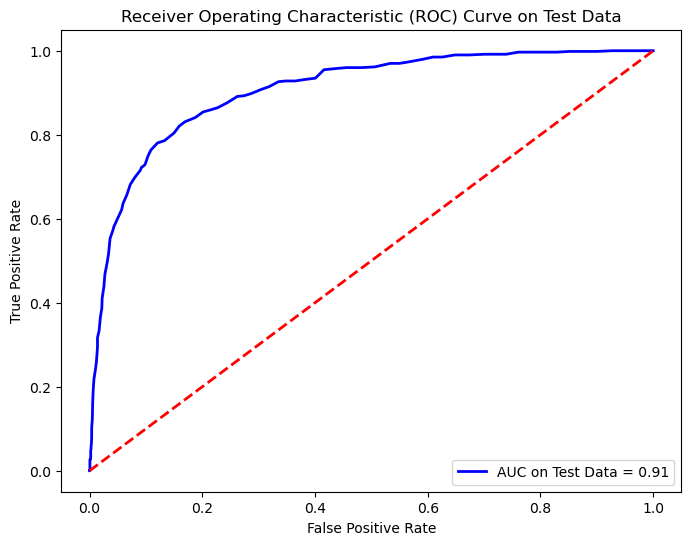

In [19]:
# Get predicted probabilities for test data
probs_test = rf_classifier.predict_proba(reshaped_features_test)
preds_test = probs_test[:, 1]

# Calculate ROC curve and AUC for test data
fpr_test, tpr_test, threshold_test = roc_curve(flattened_labels_test, preds_test)
roc_auc_test = auc(fpr_test, tpr_test)
# Plot ROC curve for test data
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'AUC on Test Data = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on Test Data')
plt.legend(loc='lower right')
plt.show()

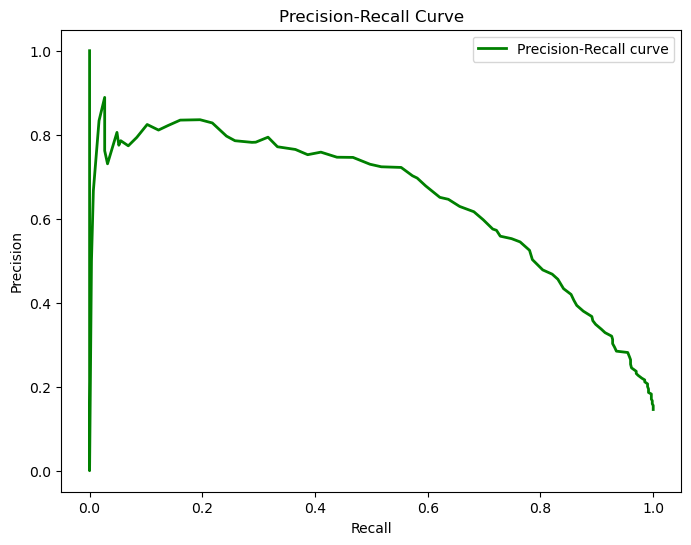

In [20]:
precision, recall, _ = precision_recall_curve(flattened_labels_test, preds_test)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


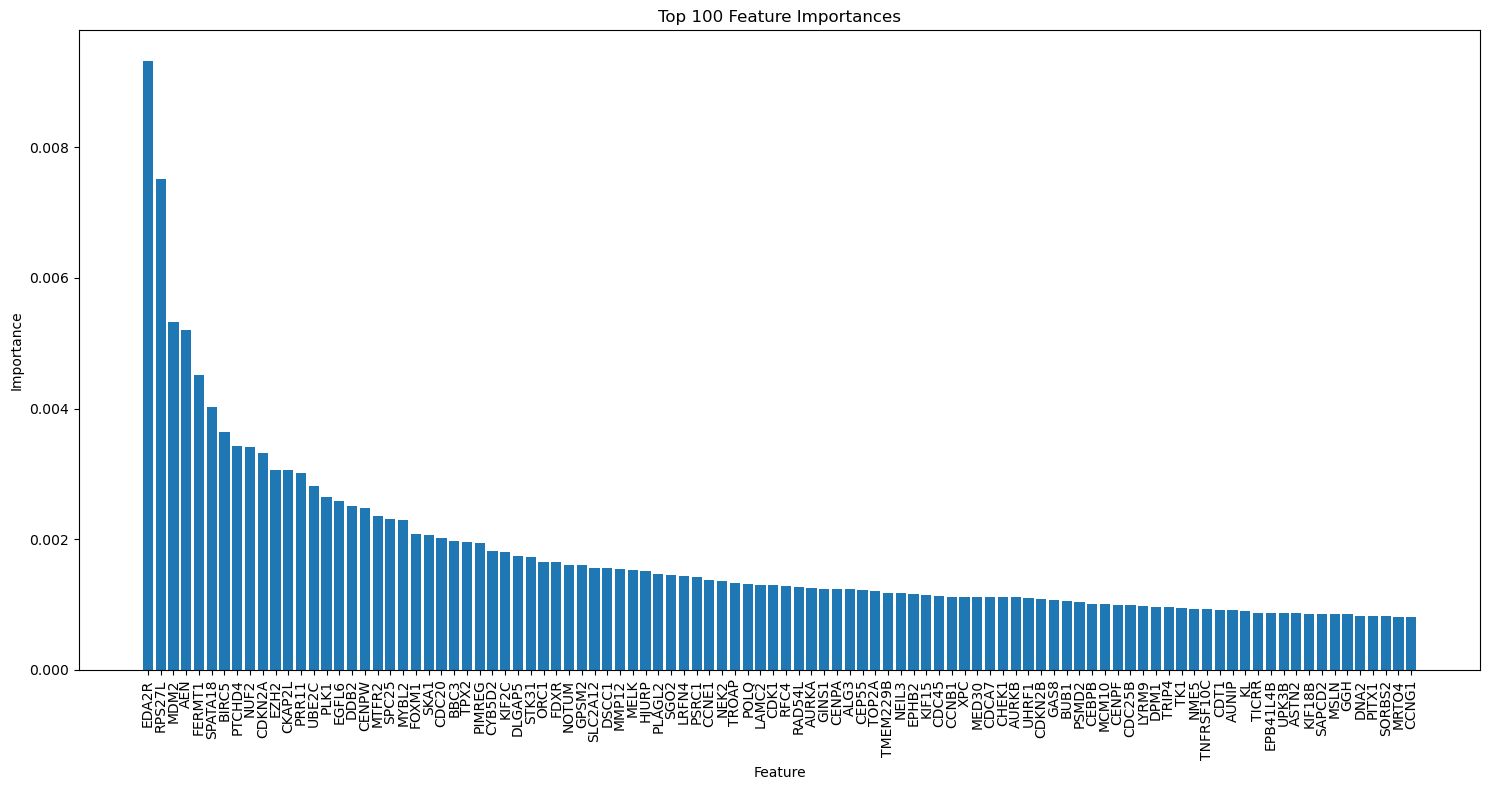

In [21]:
feature_importances = rf_classifier.feature_importances_
feature_names = dataset.columns[:-1]  # Excluding the target variable
sorted_indices = np.argsort(feature_importances)[::-1]

top_feature_importances = feature_importances[sorted_indices][:100]
top_feature_names = feature_names[sorted_indices][:100]

plt.figure(figsize=(15, 8))  # Adjust the figure size as needed
plt.bar(range(100), top_feature_importances, align='center')
plt.xticks(range(100), top_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 100 Feature Importances')
plt.tight_layout()  # To ensure labels fit within the figure
plt.show()

Mainly p53 regulators

Confusion Matrix on Test Data:
[[3177  322]
 [ 166  431]]


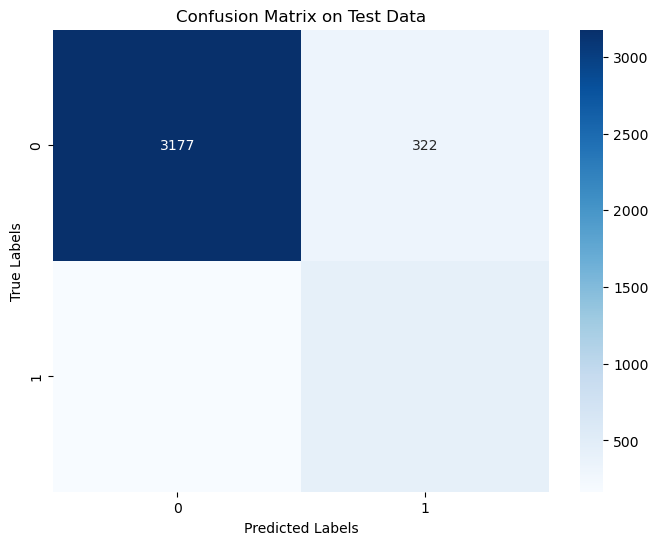

In [22]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(flattened_labels_test, predictions_test)
print("Confusion Matrix on Test Data:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Data')
plt.show()

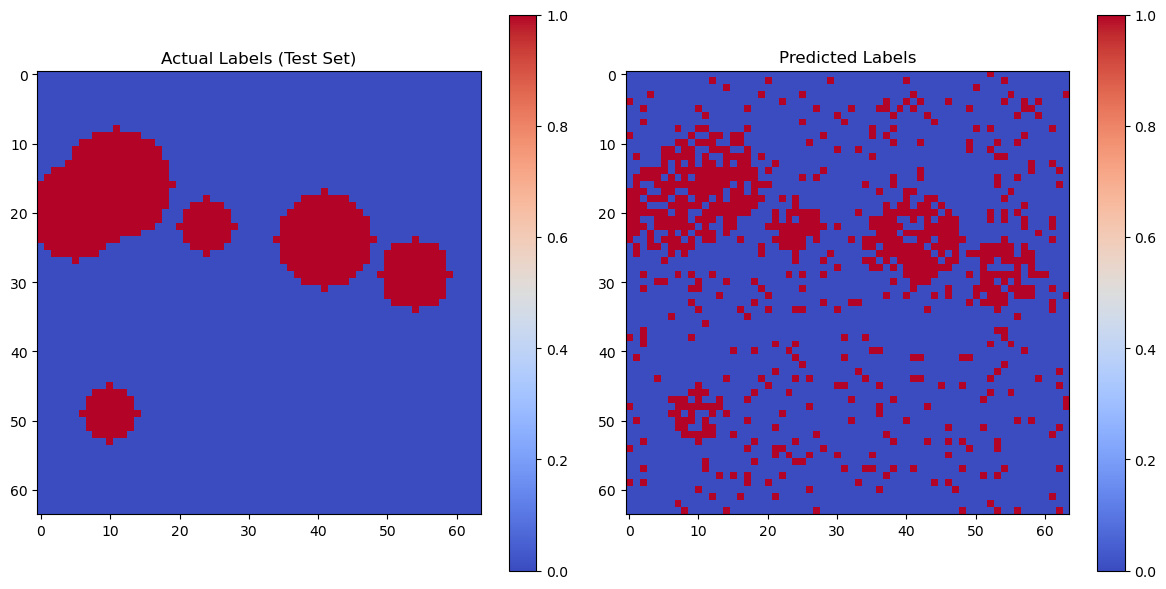

In [23]:
# Reshape predicted labels back into a grid
predicted_grid = predictions_test.reshape(grid_size, grid_size)

# Create subplots to compare actual labels and predicted labels
plt.figure(figsize=(12, 6))

# Plot for actual labels
plt.subplot(1, 2, 1)
plt.imshow(labels_test, cmap='coolwarm', interpolation='nearest')
plt.title('Actual Labels (Test Set)')
plt.colorbar()

# Plot for predicted labels
plt.subplot(1, 2, 2)
plt.imshow(predicted_grid, cmap='coolwarm', interpolation='nearest')
plt.title('Predicted Labels')
plt.colorbar()

plt.tight_layout()
plt.show()


# ADDENDUM : Using only most important genes

### Bootstrap to find ideal number of top features

In [37]:
# Get feature importances from the trained model
feature_importances = rf_classifier.feature_importances_

# Exclude the 'mutated' column from feature names
feature_names = X_train.columns[X_train.columns != 'mutated']  

# Sort feature indices based on importances
sorted_indices = np.argsort(feature_importances)[::-1]

num_top_features = 2001
top_feature_indices = sorted_indices[:num_top_features]
top_feature_names = feature_names[top_feature_indices]

# The code for feature importances, selecting top features, and model training remains the same as before

# Lists to store results
accuracies = []
precisions_0 = []
precisions_1 = []
recalls_0 = []
recalls_1 = []
f1_scores_0 = []
f1_scores_1 = []
optimal_num_features_list = []

# Iterate through different numbers of top features
for num_top_features in range(448, 452, 1):
    # Create a new dataset using only the top features
    X_train_top = X_train[top_feature_names[:num_top_features]]
    X_test_top = X_test[top_feature_names[:num_top_features]]

    # Re-train the Random Forest model using only the selected top features
    rf_classifier_top = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_top.fit(X_train_top, y_train)

    # Predict using the model trained on top features
    predictions_test_top = rf_classifier_top.predict(X_test_top)

    # Calculate accuracy
    accuracy_test_top = accuracy_score(y_test, predictions_test_top)
    accuracies.append(accuracy_test_top)
    optimal_num_features_list.append(num_top_features)  # Store the number of features used

    # Additional evaluation metrics for the model using top features
    report = classification_report(y_test, predictions_test_top, output_dict=True)
    precisions_0.append(report['0']['precision'])
    precisions_1.append(report['1']['precision'])
    recalls_0.append(report['0']['recall'])
    recalls_1.append(report['1']['recall'])
    f1_scores_0.append(report['0']['f1-score'])
    f1_scores_1.append(report['1']['f1-score'])

# Find the index of the maximum accuracy
max_accuracy_index = np.argmax(accuracies)
optimal_num_features = optimal_num_features_list[max_accuracy_index]

# Print results
print(f"Optimal number of features for maximum accuracy: {optimal_num_features}")
print(f"Maximum accuracy achieved: {accuracies[max_accuracy_index]}")
print(f"Precision for class 0: {precisions_0[max_accuracy_index]}")
print(f"Precision for class 1: {precisions_1[max_accuracy_index]}")
print(f"Recall for class 0: {recalls_0[max_accuracy_index]}")
print(f"Recall for class 1: {recalls_1[max_accuracy_index]}")
print(f"F1-score for class 0: {f1_scores_0[max_accuracy_index]}")
print(f"F1-score for class 1: {f1_scores_1[max_accuracy_index]}")


Optimal number of features for maximum accuracy: 450
Maximum accuracy achieved: 0.8795683954054995
Precision for class 0: 0.8918918918918919
Precision for class 1: 0.8559837728194726
Recall for class 0: 0.9221917808219178
Recall for class 1: 0.8053435114503816
F1-score for class 0: 0.9067887931034483
F1-score for class 1: 0.8298918387413962


450 is the optimal number

### Use top 450 features

In [50]:
# Functions

def evaluate_model(predictions, y_test):
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy on Test Data: {accuracy}")

    print("Classification Report on Test Data:")
    print(classification_report(y_test, predictions))

    print("Confusion Matrix on Test Data:")
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)

    return accuracy, conf_matrix

def plot_roc_curve(preds_test, y_test):
    fpr, tpr, threshold = roc_curve(y_test, preds_test)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC on Test Data = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(preds_test, y_test):
    precision, recall, _ = precision_recall_curve(y_test, preds_test)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

def plot_feature_importances(rf_classifier, top_feature_indices, top_feature_names):
    feature_importances = rf_classifier.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]

    top_feature_importances = feature_importances[sorted_indices][:100]
    top_feature_names = top_feature_names[sorted_indices][:100]

    plt.figure(figsize=(15, 8))
    plt.bar(range(100), top_feature_importances, align='center')
    plt.xticks(range(100), top_feature_names, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Top 100 Feature Importances')
    plt.tight_layout()
    plt.show()

In [51]:
# Get feature importances from the trained model
feature_importances = rf_classifier.feature_importances_
feature_names = X_train.columns[X_train.columns != 'mutated']  
sorted_indices = np.argsort(feature_importances)[::-1]
num_top_features = 450  
top_feature_indices = sorted_indices[:num_top_features]
top_feature_names = feature_names[top_feature_indices]

X_train_top = X_train[top_feature_names]
X_test_top = X_test[top_feature_names]

In [52]:
# Re-train the Random Forest model using only the selected top features
rf_classifier_top = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_top.fit(X_train_top, y_train)
predictions_test_top = rf_classifier_top.predict(X_test_top)

Accuracy on Test Data: 0.8795683954054995
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1825
           1       0.86      0.81      0.83      1048

    accuracy                           0.88      2873
   macro avg       0.87      0.86      0.87      2873
weighted avg       0.88      0.88      0.88      2873

Confusion Matrix on Test Data:
[[1683  142]
 [ 204  844]]


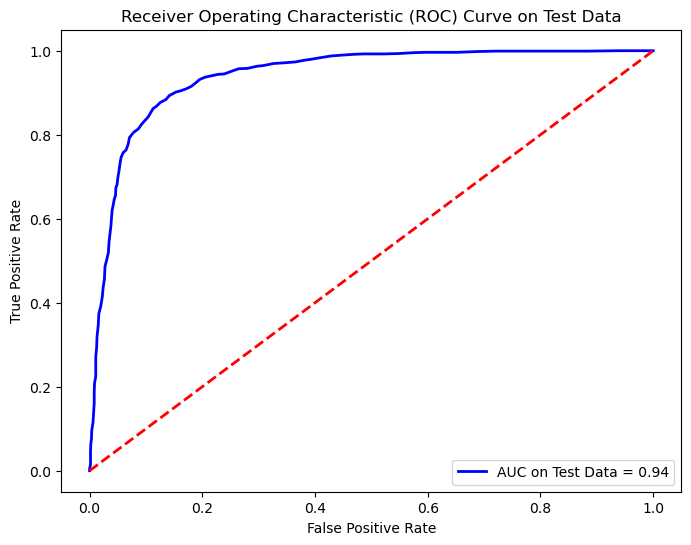

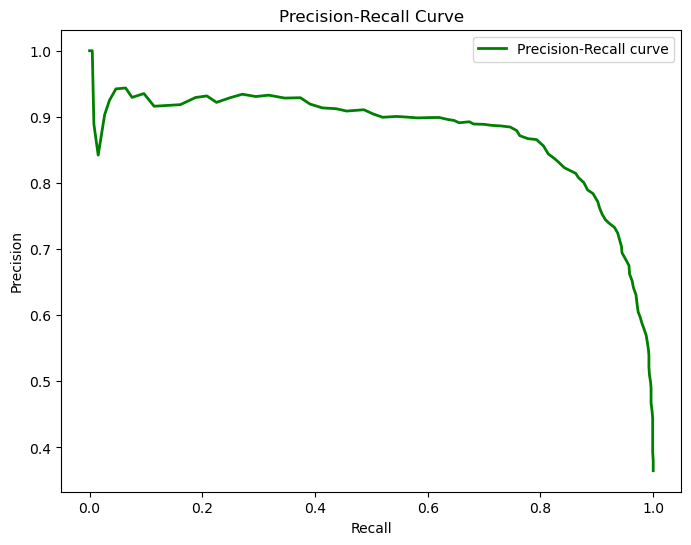

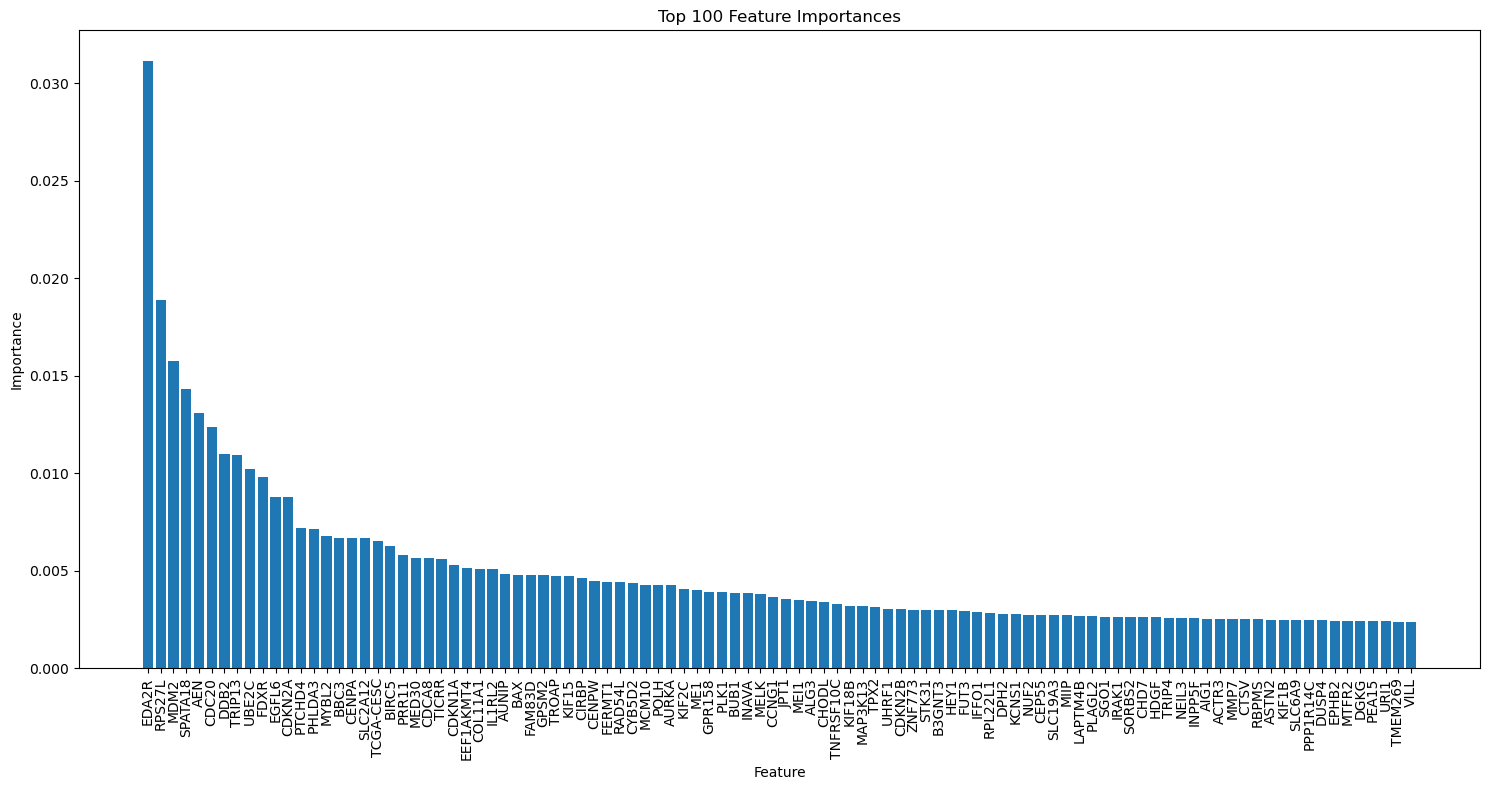

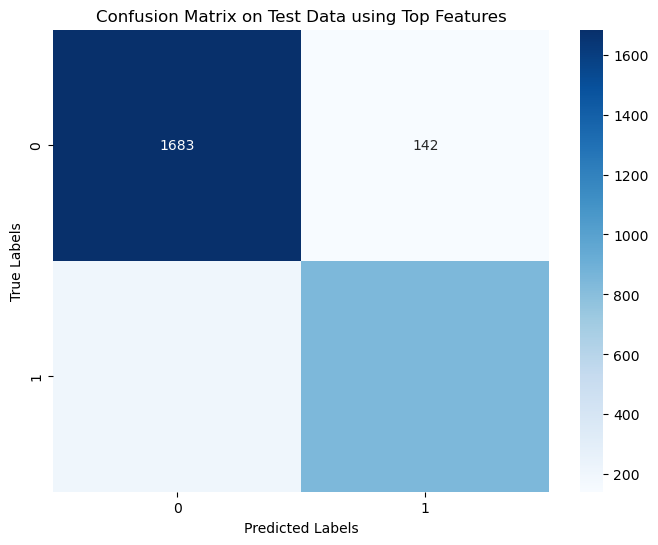

In [53]:
# Evaluate the performance of the model using only top features
accuracy_test_top, conf_matrix_top = evaluate_model(predictions_test_top, y_test)

# Plot ROC curve for test data using top features
probs_test_top = rf_classifier_top.predict_proba(X_test_top)
preds_test_top = probs_test_top[:, 1]
plot_roc_curve(preds_test_top, y_test)

# Plot Precision-Recall curve for test data using top features
plot_precision_recall_curve(preds_test_top, y_test)

# Plot feature importances using top features
plot_feature_importances(rf_classifier_top, top_feature_indices, top_feature_names)

# Plot Confusion Matrix for test data using top features
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_top, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Data using Top Features')
plt.show()


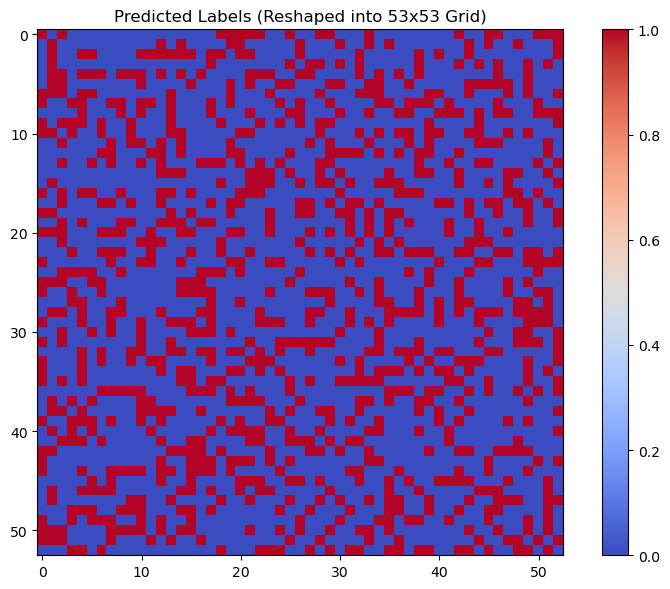

In [63]:
num_predictions = len(predictions_test_top)
grid_size = 53

# Reduce predictions to match the grid size
reduced_predictions = predictions_test_top[:grid_size * grid_size]
# Reshape reduced predictions into a 53x53 grid
predicted_grid = reduced_predictions.reshape(grid_size, grid_size)
# Display the grid
plt.figure(figsize=(8, 6))
plt.imshow(predicted_grid, cmap='coolwarm', interpolation='nearest')
plt.title('Predicted Labels (Reshaped into 53x53 Grid)')
plt.colorbar()
plt.tight_layout()
plt.show()